In [78]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import random

In [79]:
df = pd.read_csv("TRY4Full2013_2022Data.csv")
#pd.reset_option('display.max_columns')
pd.set_option('display.max_columns', None)

df.head()
random.seed(530)

In [80]:
df_subset = df.dropna(subset=["number fatalities",
                              "number injury > 3 days lost time",
                              "number injury > 3 days restricted work/job transfer",
                              "number injury 1-3 days lost time",
                              "number injury 1-3 days restricted work/job transfer",
                              "number of injury no lost time"])

df_subset["Fatalities_and_Injury"] = df_subset[["number fatalities",
                              "number injury > 3 days lost time",
                              "number injury > 3 days restricted work/job transfer",
                              "number injury 1-3 days lost time",
                              "number injury 1-3 days restricted work/job transfer",
                              "number of injury no lost time"]].sum(axis=1)

df_subset["Cat_Fatalities_and_Injury"] = np.where(df_subset["Fatalities_and_Injury"] >= 1, "Yes", "No")


# Columns to remove
columns_to_remove = [
    'Fatalities_and_Injury',
    'number of injury no lost time',
    'number injury > 3 days restricted work/job transfer',
    'number injury > 3 days lost time',
    'number injury 1-3 days lost time',
    'number injury 1-3 days restricted work/job transfer',
    'number fatalities',
    'year'
]

# Drop the columns
df_subset = df_subset.drop(columns=columns_to_remove)

df_subset.tail()
#df_subset.to_csv("Data_for_prediction", index=False)


/var/folders/fq/n8rn1dtx6k34rv37c81hq01w0000gn/T/ipykernel_4551/2375934946.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["Fatalities_and_Injury"] = df_subset[["number fatalities",
/var/folders/fq/n8rn1dtx6k34rv37c81hq01w0000gn/T/ipykernel_4551/2375934946.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["Cat_Fatalities_and_Injury"] = np.where(df_subset["Fatalities_and_Injury"] >= 1, "Yes", "No")


,date,time,company name,district (2010),panel,ocs region,district name,area name,block,lease,water depth (feet),distance to shore (miles),structure name,structure type,rig name,rig type,pipeline segment number,incident summary,explosion,fire,loss of well control (underground),loss of well control (surface),loss of well control (diverter),loss of well control (equipment failure/improper procedure),major collision (property damage > $25k),minor collision (property damage < S25k),crane,other lifting device,other lifting device name,reportable h2s release,shut down gas release,required muster,exploration,development production,drilling,workover,completion,motor vessel,pipeline,helicopter,other,other operation description,equipment failure,human error,slip trip fall,weather,external damage,leak,upset h2o,overboard fluid,other cause,other cause description,Cat_Fatalities_and_Injury
6026,44924,1400.0,Shell Offshore Inc.,N,NaN,Gulf of Mexico,Lake Jackson,Alaminos Canyon,857,G17565,7835,140,NaN,NaN,H&P 205,Platform,NaN,"Rig Details: GA 021 ST01BP00, Lease - G24593, ...",N,N,N,N,N,N,N,N,N,N,NaN,N,N,N,N,Y,N,N,Y,N,N,N,N,NaN,N,N,N,N,N,N,N,N,N,NaN,Yes
6027,44924,915.0,Chevron U.S.A. Inc.,N,NaN,Gulf of Mexico,Houma,Green Canyon,205,G05911,2200,80,A-Genesis Spar,SPAR,NaN,NaN,NaN,The crane operator received directions from th...,N,N,N,N,N,N,N,N,Y,N,NaN,N,N,N,N,Y,N,N,N,N,N,N,N,NaN,N,N,N,N,N,N,N,N,N,NaN,No
6028,44925,2130.0,BP Exploration & Production Inc.,N,NaN,Gulf of Mexico,Houma,Green Canyon,743,G15607,6863,122,NaN,NaN,DIAMOND WEST AURIGA,Drillship,NaN,Crew was in the process of running VACS tool a...,N,N,N,N,N,N,N,N,N,Y,Elevators,N,N,N,N,Y,N,N,Y,N,N,N,N,NaN,N,N,N,N,N,N,N,N,N,NaN,No
6029,44926,1230.0,Hess Corporation,N,NaN,Gulf of Mexico,Houma,Green Canyon,468,G26313,3360,109,A (STAMPEDE),TLP,NaN,NaN,NaN,Initial Report:\r\nSubject: [EXTERNAL] Hess - ...,N,Y,N,N,N,N,N,N,N,N,NaN,N,N,N,N,Y,N,N,N,N,N,N,N,NaN,N,N,N,N,N,N,N,N,N,NaN,No
6031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,126,1,3,0,1,4,2,283,50,NaN,3,54,108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes


In [81]:
df_subset.shape

(2945, 53)

In [82]:
# Random forest model 

# Preprocess the data
df_subset = df_subset.dropna(subset=['Cat_Fatalities_and_Injury'])


# Extract features and target variable from the training set
X = df_subset.drop(columns=['Cat_Fatalities_and_Injury'])
y = df_subset["Cat_Fatalities_and_Injury"]

# Identify categorical columns in the dataset
categorical_cols = X.select_dtypes(include=['object']).columns

# Identify quantative columns in the dataset
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Split the data into training and testing sets- 80% is train, and 20% is test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Create transformers for numerical and categorical columns

# numerical- replace NA's with mean and scale the data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# categorical- replace NA's with the most frequent value and ignore any new value in the 
# test data that has not appeared in the training set.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Create a preprocessor to apply transformers to appropriate columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


# Apply preprocessing steps to the data
preprocessed_data = preprocessor.fit_transform(X)



In [83]:
# Initialize RF model
rf_model = RandomForestClassifier()

# Create a pipeline with the preprocessor and RandomForestRegressor model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

# Fit the model to the training data
model.fit(X_train, y_train)


# Currently the model is overfit, will need to tune the hyperparameters

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['time', 'pipeline segment number'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['date', 'company...
       'exploration', 'development production', 'drilling', 'workover',
       'completion', 'motor vessel', 'pipeline', 'helicopter', 'other',
       'other operation description', 'equipment failure', 'human error',
       'slip trip fall', 'weather', 'external damage', 'leak', 'upset h2o',
       'overboard fluid', 'other cause', 'other cause description'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier())])

In [84]:
# using Cross-Validation to tune the hyperparameters of RF model

param_grid = {
    'classifier__n_estimators': [75, 100, 150],
    'classifier__max_depth': [2, 5, 10],
    'classifier__min_samples_split': [14, 16, 18],
    'classifier__min_samples_leaf': [2, 3, 6]
}


# Create a pipeline with the preprocessor and Random Forest model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])


# Instantiate GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(model,  # Use the entire pipeline here
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='accuracy', 
                           n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score found
print("Best Parameters:", grid_search.best_params_)



Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 14, 'classifier__n_estimators': 150}


In [85]:
# Get the best estimator
best_model_RF = grid_search.best_estimator_

# Tuned RF model's accuracy on train and test
y_train_pred = best_model_RF.predict(X_train)
y_test_pred = best_model_RF.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

# Additional performance metrics
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

Training Accuracy: 75.00%
Testing Accuracy: 76.23%

Training Classification Report:
              precision    recall  f1-score   support

          No       0.75      1.00      0.86      1764
         Yes       1.00      0.01      0.01       592

    accuracy                           0.75      2356
   macro avg       0.87      0.50      0.43      2356
weighted avg       0.81      0.75      0.64      2356

Testing Classification Report:
              precision    recall  f1-score   support

          No       0.76      1.00      0.87       449
         Yes       0.00      0.00      0.00       140

    accuracy                           0.76       589
   macro avg       0.38      0.50      0.43       589
weighted avg       0.58      0.76      0.66       589

Confusion Matrix (Test):
[[449   0]
 [140   0]]


/Users/meetpatel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/meetpatel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/meetpatel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [86]:
# Calculate AUC
y_test_prob = best_model_RF.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_test_prob)
print(f"AUC: {auc:.2f}")




AUC: 0.82


In [87]:
# Access the Random Forest model from the Pipeline
random_forest_model = best_model_RF.named_steps['classifier']  # Ensure 'regressor' is the correct step name

# Access the feature importances
feature_importances = random_forest_model.feature_importances_

# Get the preprocessor from the pipeline
preprocessor = best_model_RF.named_steps['preprocessor']

# Get the indices of the top 25 features
top_feature_indices = np.argsort(feature_importances)[::-1][:10]

# Get the one-hot encoded feature names for categorical columns
categorical_cols = preprocessor.transformers_[1][2]
one_hot_encoded_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)

# Get the numerical column names
numerical_cols = preprocessor.transformers_[0][2]

# Combine numerical and one-hot encoded feature names
all_feature_names = list(numerical_cols) + list(one_hot_encoded_feature_names)

# Get the names of the top features
top_feature_names = [all_feature_names[i] for i in top_feature_indices]

# Print the top feature names
print("Top 25 features:")
print(top_feature_names)


Top 25 features:
['fire_Y', 'crane_Y', 'fire_N', 'crane_N', 'required muster_N', 'required muster_Y', 'shut down gas release_Y', 'slip trip fall_N', 'slip trip fall_Y', 'shut down gas release_N']


In [88]:
# Inspect the pipeline steps to find the correct name
print(best_model_RF.named_steps)


{'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['time', 'pipeline segment number'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['date', 'company name', 'district (2010)', 'panel', '...
       'reportable h2s release', 'shut down gas release', 'required muster',
       'exploration', 'development production', 'drilling', 'workover',
       'completion', 'motor vessel', 'pipeline', 'helicopter', 'other',
       'other operation d

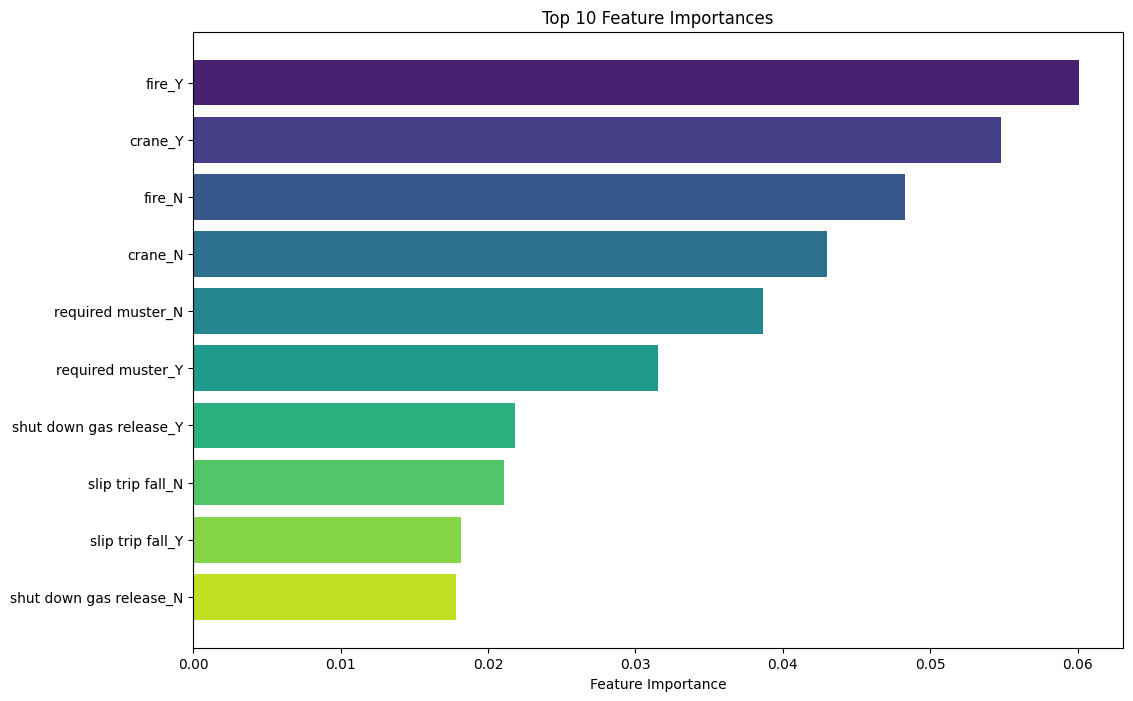

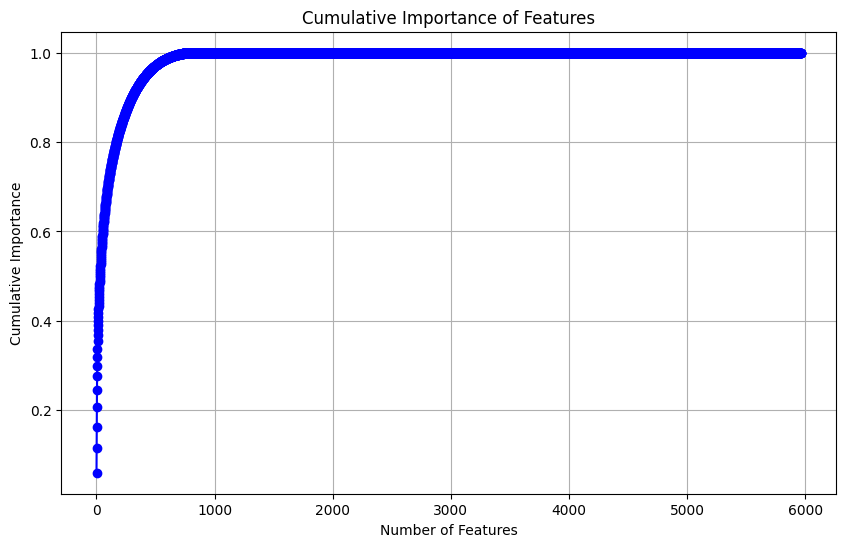

In [89]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the necessary variables from your previous steps are available:
# feature_importances, top_feature_indices, top_feature_names, all_feature_names

# Bar chart of the top 25 feature importances
def plot_top_features(top_feature_names, feature_importances, top_feature_indices):
    top_features = np.array(top_feature_names)
    top_importances = feature_importances[top_feature_indices]
    
        # Apply the Viridis color palette from Seaborn
    colors = sns.color_palette('viridis', len(top_features))

    plt.figure(figsize=(12, 8))
    plt.barh(top_features, top_importances, color=colors)
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Feature Importances')
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.show()

# Cumulative importance line chart
def plot_cumulative_importance(feature_importances):
    sorted_importances = np.sort(feature_importances)[::-1]
    cumulative_importances = np.cumsum(sorted_importances)
    feature_indices = range(1, len(sorted_importances) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(feature_indices, cumulative_importances, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Importance')
    plt.title('Cumulative Importance of Features')
    plt.grid(True)
    plt.show()

# Comparison of numerical and categorical feature importances
def plot_numerical_vs_categorical_importance(feature_importances, all_feature_names, numerical_cols, one_hot_encoded_feature_names):
    numerical_importances = [feature_importances[i] for i, name in enumerate(all_feature_names) if name in numerical_cols]
    categorical_importances = [feature_importances[i] for i, name in enumerate(all_feature_names) if name in one_hot_encoded_feature_names]
    
    plt.figure(figsize=(14, 6))

    # Numerical feature importances
    plt.subplot(1, 2, 1)
    plt.barh(numerical_cols, numerical_importances, color='lightgreen')
    plt.xlabel('Feature Importance')
    plt.title('Numerical Feature Importances')
    plt.gca().invert_yaxis()

    # Categorical feature importances
    plt.subplot(1, 2, 2)
    plt.barh(one_hot_encoded_feature_names, categorical_importances, color='lightcoral')
    plt.xlabel('Feature Importance')
    plt.title('Categorical Feature Importances')
    plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()

# Plot the charts
plot_top_features(top_feature_names, feature_importances, top_feature_indices)
plot_cumulative_importance(feature_importances)
#plot_numerical_vs_categorical_importance(feature_importances, all_feature_names, numerical_cols, one_hot_encoded_feature_names)


In [31]:
# Random forest model 

# Preprocess the data
df_rf = df.dropna(subset=['number fatalities'])


# Extract features and target variable from the training set
X = df_rf.drop(columns=['number fatalities'])
y = df_rf["number fatalities"]

# Identify categorical columns in the dataset
categorical_cols = X.select_dtypes(include=['object']).columns

# Identify quantative columns in the dataset
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Split the data into training and testing sets- 80% is train, and 20% is test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Create transformers for numerical and categorical columns

# numerical- replace NA's with mean and scale the data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# categorical- replace NA's with the most frequent value and ignore any new value in the 
# test data that has not appeared in the training set.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Create a preprocessor to apply transformers to appropriate columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


# Apply preprocessing steps to the data
preprocessed_data = preprocessor.fit_transform(X)



In [32]:
# using Cross-Validation to tune the hyperparameters of RF model

param_grid = {
    'regressor__n_estimators': [75, 100, 150],
    'regressor__max_depth': [2, 5, 10],
    'regressor__min_samples_split': [14, 16, 18],
    'regressor__min_samples_leaf': [2,3,6]
}

# Create a pipeline with the preprocessor and Random Forest model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf_model)
])

# Instantiate GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(model,  # Use the entire pipeline here
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score found
print("Best Parameters:", grid_search.best_params_)

/Users/meetpatel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'regressor__max_depth': 2, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 14, 'regressor__n_estimators': 75}


In [33]:
# Best model

best_model_RF = grid_search.best_estimator_

# Tuned RF model's accuracy on train and test
y_train_pred = best_model_RF.predict(X_train)
y_test_pred = best_model_RF.predict(X_test)

RMSE_train = np.sqrt(MSE(y_train, y_train_pred))
RMSE_test = np.sqrt(MSE(y_test, y_test_pred))

print(f"Training RMSE score: {RMSE_train}")
print(f"Testing RMSE score: {RMSE_test}")

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"\nTraining R^2 score: {np.round(r2_train*100,2)}%")
print(f"Testing R^2 score: {np.round(r2_test*100,2)}%")

Training RMSE score: 0.12170324592101288
Testing RMSE score: 0.11634594543263001

Training R^2 score: -0.89%
Testing R^2 score: -0.77%


In [34]:
# Select the top 25 features that are automatically selected by RF

# Get the Random Forest model from the Pipeline
random_forest_model = best_model_RF.named_steps['regressor']

# Access the feature importances
feature_importances = random_forest_model.feature_importances_

# Get the preprocessor from the pipeline
preprocessor = best_model_RF.named_steps['preprocessor']

# Get the indices of the top features
top_feature_indices = np.argsort(feature_importances)[::-1][:25]

# Get the categorical columns
categorical_cols = preprocessor.transformers_[1][2]

# Get the one-hot encoded feature names for categorical columns (creating dummy variables)
one_hot_encoded_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)

# Get the numerical column names
numerical_cols = preprocessor.transformers_[0][2]

# Combine numerical and one-hot encoded feature names
all_feature_names = list(numerical_cols) + list(one_hot_encoded_feature_names)

# Get the names of the top features
top_feature_names = [all_feature_names[i] for i in top_feature_indices]

# Print the top feature names
print("Top 25 features:")
print(top_feature_names)

Top 25 features:
['year', 'date_44494', 'panel_N', 'water depth (feet)_63', 'incident summary_An occupational fatality occurred.', 'lease_G24102', 'workover_N', 'number injury 1-3 days lost time', 'block_826', 'water depth (feet)_61', 'company name_TOTAL E&P USA, INC.', 'lease_G33644', 'block_157', 'block_107', 'district (2010)_N', 'explosion_Y', 'district name_New Orleans', 'rig type_Drillship', 'explosion_N', 'block_215', 'panel_Y', 'date_43844', 'date_44331', 'date_43877', 'block_6862']


In [35]:
# Variables for further analysis: 

# water depth, distance to shore, incident summary, 
# loss of well control (surface), lease, loss of well control (underground)

In [36]:
# XG Boost

from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Assume df contains your dataframe


# Preprocess the data
df_rf = df.dropna(subset=['number fatalities'])

# Extract features and target variable from the training set
X = df_rf.drop(columns=['number fatalities'])
y = df_rf["number fatalities"]

# Identify categorical columns in the dataset
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define the model
model = XGBRegressor()

# Create and evaluate the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)


rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

print("RMSE on training set:", rmse_train)
print("RMSE on test set:", rmse_test)

# Calculate R^2 score for training set
r2_train = r2_score(y_train, y_pred_train)

# Calculate R^2 score for test set
r2_test = r2_score(y_test, y_pred_test)

print("R^2 score on training set:", np.round(r2_train*100,1),"%")
print("R^2 score on test set:", np.round(r2_test*100,1),"%")

RMSE on training set: 0.00010997867687476716
RMSE on test set: 0.10991778987204026
R^2 score on training set: 100.0 %
R^2 score on test set: 27.8 %


/Users/meetpatel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/meetpatel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
